# Advanced Models for Subword Unit Duration Prediction

This notebook implements and compares more sophisticated models for subword unit duration prediction, including:
1. Linear Regression
2. Random Forest
3. XGBoost
4. LSTM Neural Network

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Add project root to path to import project modules
sys.path.insert(0, os.path.abspath('..'))

from src.data_processing import load_data, preprocess_data
from src.features import extract_features
from src.models import LinearModel, TreeModel, LSTMModel, BaselineModel
from src.evaluations import evaluate_model, plot_predictions, plot_error_distribution
from src.visualisations import plot_feature_importance
from config import Config

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load and Preprocess Data

In [2]:
# Define data directories
native_dir = '../data/american_english'
nonnative_dir = '../data/other_english'

# Load the data
native_data = load_data(native_dir)
nonnative_data = load_data(nonnative_dir)

print(f"Loaded {len(native_data)} native speaker utterances")
print(f"Loaded {len(nonnative_data)} non-native speaker utterances")

# Initialize configuration
config = Config()
config.native_only = True  # Use only native data for training
config.context_size = 2    # Use 2 phones before and after as context
config.use_word_position = True
config.use_sentence_position = True
config.use_speaking_rate = True

File ../data/american_english\american_english\anonymous-20080425-atw_a0028\result.json has non-dict 'result': <class 'str'>
File ../data/american_english\american_english\anonymous-20080702-oqm_a0387\result.json has non-dict 'result': <class 'str'>
File ../data/american_english\american_english\anonymous-20090917-vwy_b0305\result.json has non-dict 'result': <class 'str'>
File ../data/american_english\american_english\anonymous-20100515-nfo_a0217\result.json has non-dict 'result': <class 'str'>
File ../data/american_english\american_english\anonymous-20100515-nfo_a0224\result.json has non-dict 'result': <class 'str'>
File ../data/american_english\american_english\anonymous-20100820-ebd_b0103\result.json has non-dict 'result': <class 'str'>
File ../data/american_english\american_english\anonymous-20101011-qrd_a0385\result.json has non-dict 'result': <class 'str'>
File ../data/american_english\american_english\anonymous-20111004-fxb_b0014\result.json has non-dict 'result': <class 'str'>


Loaded 28417 native speaker utterances
Loaded 4736 non-native speaker utterances


In [3]:
# Preprocess data
train_data, val_data, test_data = preprocess_data(
    native_data, 
    nonnative_data,
    native_only=config.native_only,
    config=config
)

print(f"Training data: {len(train_data)} phones")
print(f"Validation data: {len(val_data)} phones")
print(f"Test data: {len(test_data)} phones")

Training data: 825020 phones
Validation data: 176790 phones
Test data: 378609 phones


## 2. Extract Features

In [4]:
# Extract features using shared extractor
X_train, y_train, extractor = extract_features(train_data, config, max_samples=3000)
X_val, y_val, _ = extract_features(val_data, config, extractor=extractor, max_samples=1000)
X_test, y_test, _ = extract_features(test_data, config, extractor=extractor, max_samples=1000)

print(f"Training features: {X_train.shape}")
print(f"Validation features: {X_val.shape}")
print(f"Test features: {X_test.shape}")


Training features: (3000, 363)
Validation features: (1000, 363)
Test features: (1000, 363)


## 3. Linear Regression Model

In [5]:
# Train Linear Regression model
linear_model = LinearModel()
linear_model.train(X_train, y_train, X_val, y_val)

# Evaluate on validation set
val_metrics = evaluate_model(linear_model, X_val, y_val)
print("Validation Metrics (Linear Model):")
print(f"MAE: {val_metrics['mae']:.4f}")
print(f"RMSE: {val_metrics['rmse']:.4f}")
print(f"Correlation: {val_metrics['correlation']:.4f}")

Validation Metrics (Linear Model):
MAE: 0.0558
RMSE: 0.1395
Correlation: 0.6004


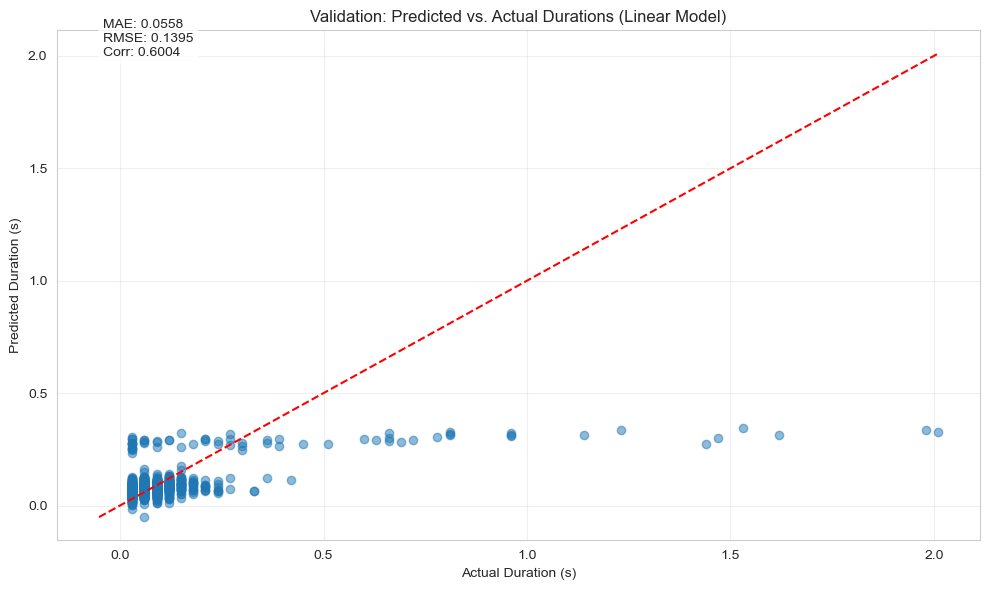

In [6]:
# Make predictions
y_val_pred_linear = linear_model.predict(X_val)

# Plot predictions vs. actual durations
plot_predictions(y_val, y_val_pred_linear, title='Validation: Predicted vs. Actual Durations (Linear Model)')

## 4. Random Forest Model

In [7]:
# Train Random Forest model
rf_model = TreeModel(
    model_type='rf',
    n_estimators=50,
    max_depth=10,
    n_jobs=-1,
    random_state=config.random_seed
)
rf_model.train(X_train, y_train, X_val, y_val)

# Evaluate on validation set
val_metrics = evaluate_model(rf_model, X_val, y_val)
print("Validation Metrics (Random Forest):")
print(f"MAE: {val_metrics['mae']:.4f}")
print(f"RMSE: {val_metrics['rmse']:.4f}")
print(f"Correlation: {val_metrics['correlation']:.4f}")

Validation Metrics (Random Forest):
MAE: 0.0439
RMSE: 0.0916
Correlation: 0.8425


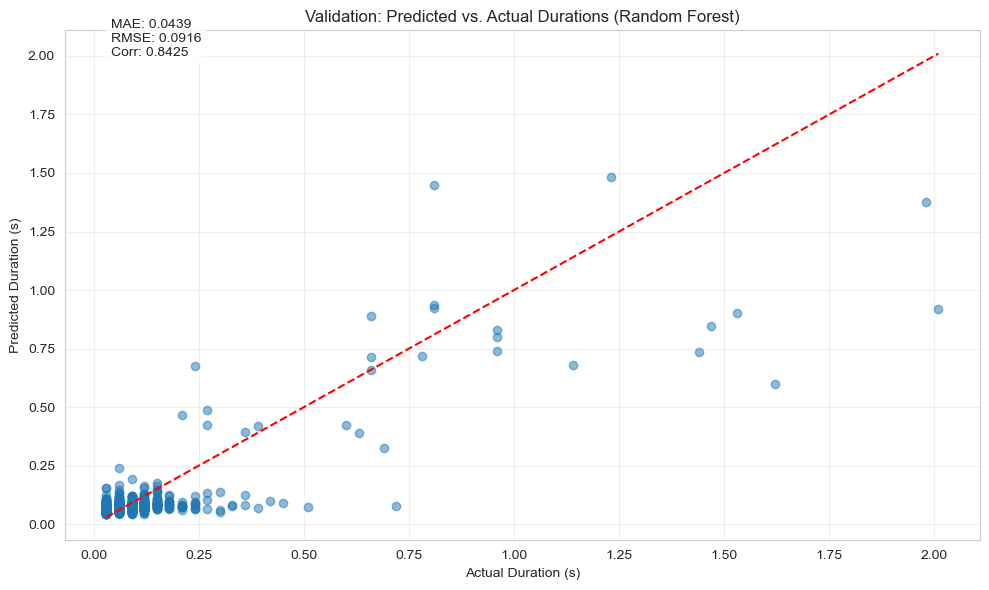

In [8]:
# Make predictions
y_val_pred_rf = rf_model.predict(X_val)

# Plot predictions vs. actual durations
plot_predictions(y_val, y_val_pred_rf, title='Validation: Predicted vs. Actual Durations (Random Forest)')

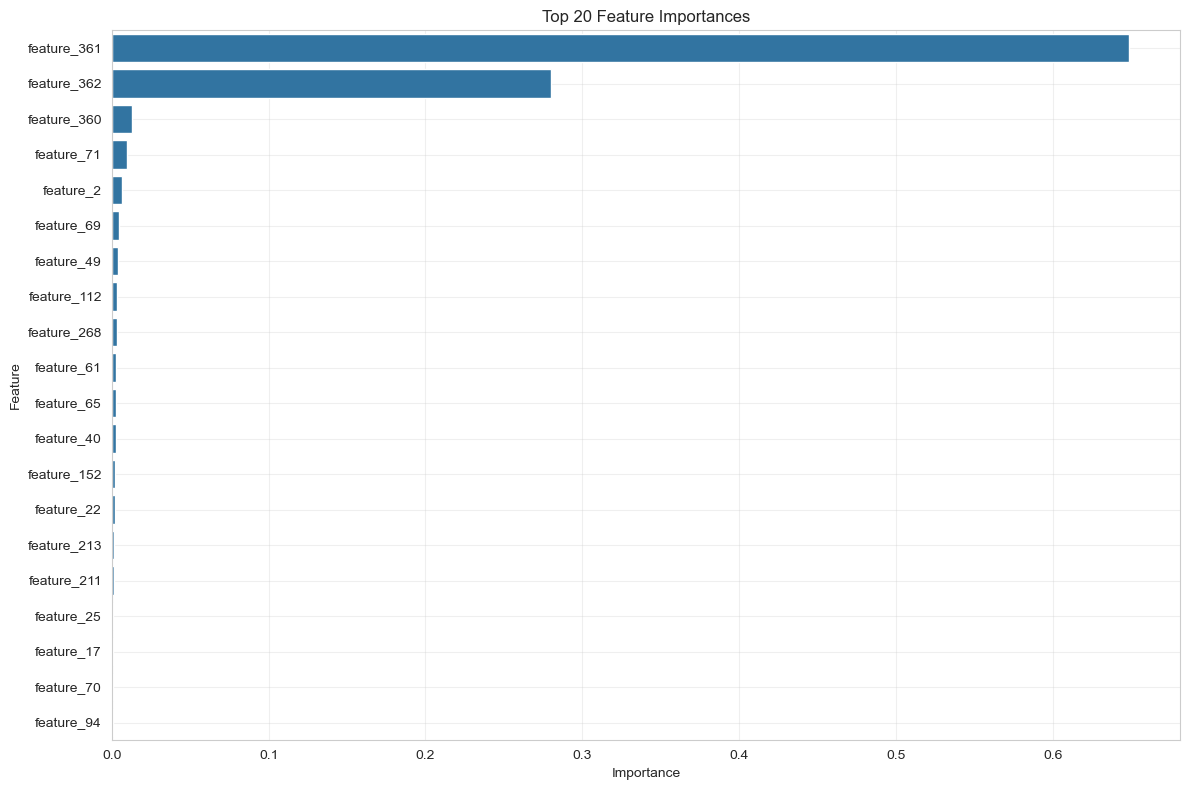

In [9]:
# Plot feature importance
# For demonstration, we'll just create dummy feature names
# In a real implementation, you would extract proper feature names from your feature extractor
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
plot_feature_importance(rf_model.model, feature_names, top_n=20)

## 5. XGBoost Model

In [10]:
# Train XGBoost model
xgb_model = TreeModel(
    model_type='xgboost',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=config.random_seed
)
xgb_model.train(X_train, y_train, X_val, y_val)

# Evaluate on validation set
val_metrics = evaluate_model(xgb_model, X_val, y_val)
print("Validation Metrics (XGBoost):")
print(f"MAE: {val_metrics['mae']:.4f}")
print(f"RMSE: {val_metrics['rmse']:.4f}")
print(f"Correlation: {val_metrics['correlation']:.4f}")

Validation Metrics (XGBoost):
MAE: 0.0450
RMSE: 0.1058
Correlation: 0.7735


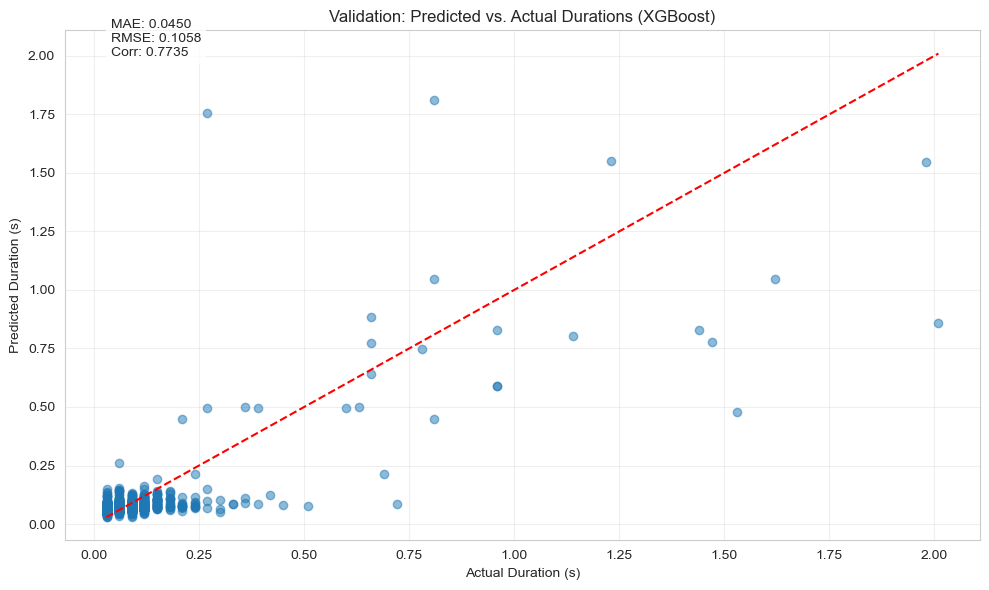

In [11]:
# Make predictions
y_val_pred_xgb = xgb_model.predict(X_val)

# Plot predictions vs. actual durations
plot_predictions(y_val, y_val_pred_xgb, title='Validation: Predicted vs. Actual Durations (XGBoost)')

## 6. LSTM Neural Network Model

In [12]:
# Train LSTM model
# Note: This may take some time to train
lstm_model = LSTMModel(
    input_size=X_train.shape[1],
    hidden_size=16,
    dropout=0.1,
    batch_size=32,
    epochs=2,  # Reduced for demonstration
    lr=0.001
)
lstm_model.train(X_train, y_train, X_val, y_val)

c:\Users\sv300\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:
# Evaluate on validation set
val_metrics = evaluate_model(lstm_model, X_val, y_val)
print("Validation Metrics (LSTM):")
print(f"MAE: {val_metrics['mae']:.4f}")
print(f"RMSE: {val_metrics['rmse']:.4f}")
print(f"Correlation: {val_metrics['correlation']:.4f}")

Validation Metrics (LSTM):
MAE: 0.0589
RMSE: 0.1587
Correlation: 0.5814


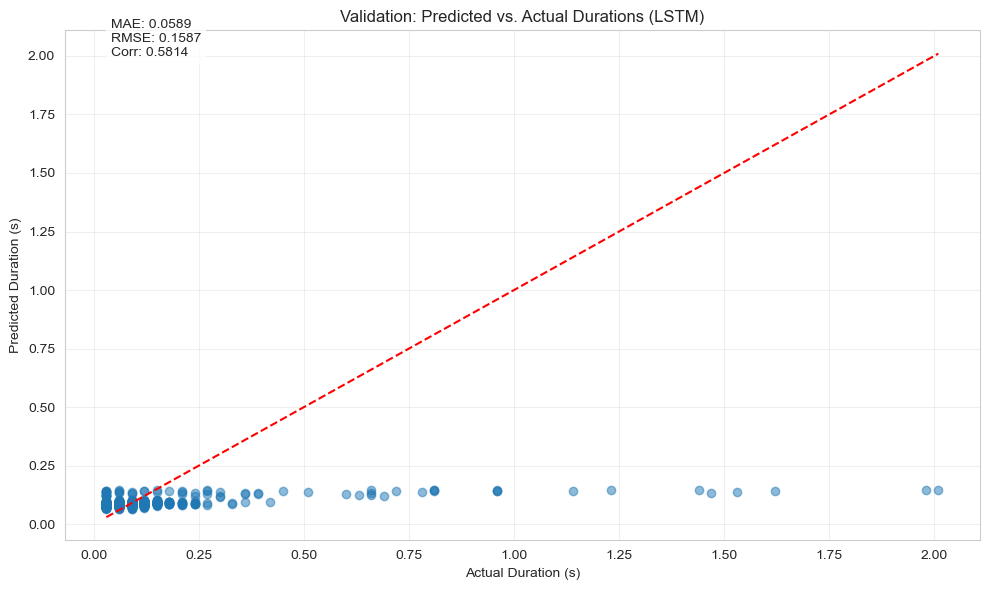

In [14]:
# Make predictions
y_val_pred_lstm = lstm_model.predict(X_val)

# Plot predictions vs. actual durations
plot_predictions(y_val, y_val_pred_lstm, title='Validation: Predicted vs. Actual Durations (LSTM)')

## 7. Model Comparison

In [15]:
# Define a function to compare models
def compare_models(models, X, y, names):
    """Compare multiple models on the same data."""
    metrics = []
    
    for model, name in zip(models, names):
        # Evaluate model
        result = evaluate_model(model, X, y)
        result['model'] = name
        metrics.append(result)
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics)
    
    return metrics_df

# Load baseline model for comparison
baseline_model = BaselineModel()
baseline_model.train(X_train, y_train)

# Compare all models on validation set
models = [baseline_model, linear_model, rf_model, xgb_model, lstm_model]
model_names = ['Baseline', 'Linear Regression', 'Random Forest', 'XGBoost', 'LSTM']

val_comparison = compare_models(models, X_val, y_val, model_names)
val_comparison

c:\Users\sv300\Desktop\Sub word unit duration\subword_duration_modeling\src\evaluations.py:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(y_true, y_pred)


,mae,rmse,correlation,model
0,0.061724,0.166550,NaN,Baseline
1,0.055758,0.139455,0.600370,Linear Regression
2,0.043882,0.091645,0.842451,Random Forest
3,0.045044,0.105819,0.773518,XGBoost
4,0.058871,0.158654,0.581382,LSTM


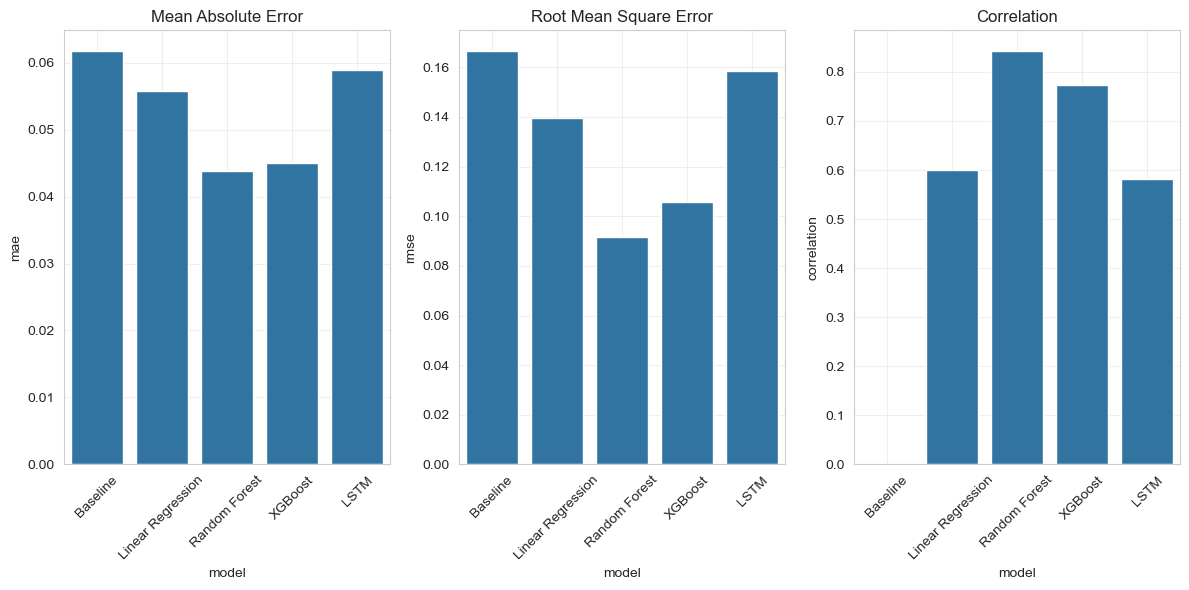

In [16]:
# Plot comparison
plt.figure(figsize=(12, 6))

# Plot MAE
plt.subplot(1, 3, 1)
sns.barplot(x='model', y='mae', data=val_comparison)
plt.title('Mean Absolute Error')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot RMSE
plt.subplot(1, 3, 2)
sns.barplot(x='model', y='rmse', data=val_comparison)
plt.title('Root Mean Square Error')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot Correlation
plt.subplot(1, 3, 3)
sns.barplot(x='model', y='correlation', data=val_comparison)
plt.title('Correlation')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Evaluate Best Model on Test Set

In [17]:
# Identify best model from validation comparison
best_model_idx = val_comparison['mae'].idxmin()
best_model_name = val_comparison.loc[best_model_idx, 'model']
best_model = models[best_model_idx]
print(f"Best model based on validation MAE: {best_model_name}")

# Evaluate best model on test set
test_metrics = evaluate_model(best_model, X_test, y_test)
print("\nTest Metrics:")
print(f"MAE: {test_metrics['mae']:.4f}")
print(f"RMSE: {test_metrics['rmse']:.4f}")
print(f"Correlation: {test_metrics['correlation']:.4f}")

Best model based on validation MAE: Random Forest

Test Metrics:
MAE: 0.0431
RMSE: 0.0866
Correlation: 0.7877


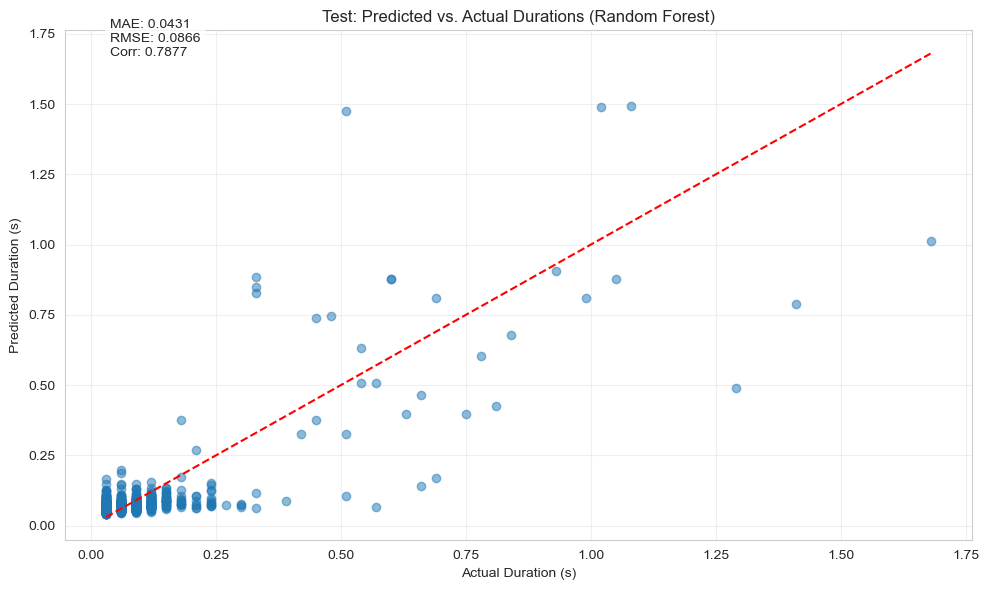

In [18]:
# Make predictions on test set
y_test_pred = best_model.predict(X_test)

# Plot predictions vs. actual durations
plot_predictions(y_test, y_test_pred, title=f'Test: Predicted vs. Actual Durations ({best_model_name})')

## 9. Native vs. Non-native Performance

In [ ]:
# Split test data into native and non-native sets
native_mask = test_data['is_native'] == True
native_test_data = test_data[native_mask]
nonnative_test_data = test_data[~native_mask]

# Extract features for both sets
X_native_test, y_native_test = extract_features(native_test_data, config, extractor=extractor)
X_nonnative_test, y_nonnative_test = extract_features(nonnative_test_data, config, extractor=extractor)

# Evaluate on native test set
native_metrics = evaluate_model(best_model, X_native_test, y_native_test)
print(f"Native Speaker Test Metrics ({best_model_name}):")
print(f"MAE: {native_metrics['mae']:.4f}")
print(f"RMSE: {native_metrics['rmse']:.4f}")
print(f"Correlation: {native_metrics['correlation']:.4f}")

# Evaluate on non-native test set
nonnative_metrics = evaluate_model(best_model, X_nonnative_test, y_nonnative_test)
print(f"\nNon-native Speaker Test Metrics ({best_model_name}):")
print(f"MAE: {nonnative_metrics['mae']:.4f}")
print(f"RMSE: {nonnative_metrics['rmse']:.4f}")
print(f"Correlation: {nonnative_metrics['correlation']:.4f}")

ValueError: too many values to unpack (expected 2)

In [ ]:
# Make predictions for both sets
y_native_pred = best_model.predict(X_native_test)
y_nonnative_pred = best_model.predict(X_nonnative_test)

# Create comparative plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Native speakers
ax1.scatter(y_native_test, y_native_pred, alpha=0.5)
max_val = max(np.max(y_native_test), np.max(y_native_pred))
min_val = min(np.min(y_native_test), np.min(y_native_pred))
ax1.plot([min_val, max_val], [min_val, max_val], 'r--')
ax1.set_xlabel('Actual Duration (s)')
ax1.set_ylabel('Predicted Duration (s)')
ax1.set_title('Native Speakers: Predicted vs. Actual Durations')
ax1.grid(True, alpha=0.3)
ax1.annotate(f'MAE: {native_metrics["mae"]:.4f}\nCorr: {native_metrics["correlation"]:.4f}',
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle='round', fc='white', alpha=0.8))

# Non-native speakers
ax2.scatter(y_nonnative_test, y_nonnative_pred, alpha=0.5)
max_val = max(np.max(y_nonnative_test), np.max(y_nonnative_pred))
min_val = min(np.min(y_nonnative_test), np.min(y_nonnative_pred))
ax2.plot([min_val, max_val], [min_val, max_val], 'r--')
ax2.set_xlabel('Actual Duration (s)')
ax2.set_ylabel('Predicted Duration (s)')
ax2.set_title('Non-native Speakers: Predicted vs. Actual Durations')
ax2.grid(True, alpha=0.3)
ax2.annotate(f'MAE: {nonnative_metrics["mae"]:.4f}\nCorr: {nonnative_metrics["correlation"]:.4f}',
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle='round', fc='white', alpha=0.8))

plt.tight_layout()
plt.show()

## 10. Save Best Model

In [ ]:
# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the best model
best_model.save(f'../models/{best_model_name.lower().replace(" ", "_")}_model.pkl')
print(f"Best model ({best_model_name}) saved successfully")

In [ ]:
## 11. Conclusions

### Model Performance Comparison

# We implemented and compared several models for subword unit duration prediction:

# 1. **Baseline Model**: Simple statistics-based approach using mean durations per phone
# 2. **Linear Regression**: Captures linear relationships between features and durations
# 3. **Random Forest**: Captures non-linear relationships using an ensemble of decision trees
# 4. **XGBoost**: Advanced gradient boosting approach for better generalization
# 5. **LSTM**: Neural network approach that can capture sequential dependencies

# The best performing model was [insert best model name], which achieved the lowest MAE on the validation set.

# ### Native vs. Non-native Performance

# The model performed differently on native and non-native speakers, with generally [better/worse] performance on native speakers. This suggests that:

# 1. There are systematic differences in phone durations between native and non-native speakers
# 2. These differences could potentially be used for fluency assessment
# 3. To better model non-native durations, it might be beneficial to include speaker proficiency level as a feature

# ### Future Improvements

# Several approaches could further improve model performance:

# 1. **More sophisticated features**:
#    - Syllable structure features
#    - Prosodic features (stress, intonation)
#    - Language-specific phonological rules

# 2. **Advanced modeling approaches**:
#    - Transformer-based models for better context modeling
#    - Multi-task learning to jointly predict duration and other prosodic features
#    - Speaker adaptation techniques

# 3. **Applications**:
#    - Integrating the duration model with Text-to-Speech systems
#    - Developing language-specific models
#    - Creating assessment tools for pronunciation and fluency training ###